# Tree_based_on_gini_index as measure of impurity

In [1]:
import pandas as pd
import numpy as np
import random
import math

import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint


In [2]:
#load data into panda data frame
df = pd.read_csv("mydata.txt") 

In [3]:
#spliting the data function 
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


In [4]:
#genrating a random test sample at 80/20 split 
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

In [5]:
#ditermining type of features
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

# QUESTION_1

In [6]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [7]:
feature_types = determine_type_of_feature(df)
i=0
for column in df.columns:
    print(column, "-",feature_types[i])
    i = i + 1
    

intercolumnardistance - continuous
uppermargin - continuous
lowermargin - continuous
exploitation - continuous
rownumber - continuous
modularratio - continuous
interlinearspacing - continuous
weight - continuous
peaknumber - continuous
ratio - continuous
lable - categorical


In [8]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [9]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [10]:
def calculate_overall_gini(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_gini =  (p_data_below * calculate_gini(data_below) 
                      + p_data_above * calculate_gini(data_above))
    
    return overall_gini

In [11]:
def calculate_gini(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    probability = sum(probabilities*probabilities)
    gini = 1-probability
     
    return gini

In [12]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        type_of_feature = FEATURE_TYPES[column_index]
        if type_of_feature == "continuous":
            potential_splits[column_index] = []
            for index in range(len(unique_values)):
                if index != 0:
                    current_value = unique_values[index]
                    previous_value = unique_values[index - 1]
                    potential_split = (current_value + previous_value) / 2

                    potential_splits[column_index].append(potential_split)
        
        
        elif len(unique_values) > 1:
            potential_splits[column_index] = unique_values
    
    return potential_splits

# Decision_making_using_gini index

In [13]:
def determine_best_split(data, potential_splits):
    
    
    gini_index = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_gini_index = calculate_overall_gini(data_below, data_above)
            #decision making based on gini index
            if  current_gini_index <  gini_index :
                gini_index = current_gini_index
                best_split_column = column_index
                best_split_value = value
                
    
    return best_split_column, best_split_value,

In [14]:
def decision_tree_algorithm(df, max_depth, counter=0, min_samples=2):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
    
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [15]:
gini_tree=decision_tree_algorithm(train_df,5)
pprint(gini_tree)

{'rownumber <= 0.842676': [{'intercolumnardistance <= -0.08572550000000001': [{'peaknumber <= 1.3581150000000002': [{'rownumber <= 0.485163': [{'peaknumber <= 0.4850335': [{'intercolumnardistance <= -2.6902775': [{'exploitation <= 1.0325280000000001': [{'lowermargin <= 6.327745': [{'uppermargin <= 0.8079265': [{'weight <= -1.98909': ['A',
                                                                                                                                                                                                                                                                                                                                                {'weight <= 1.829183': [{'interlinearspacing <= -0.06295150000000001': [{'interlinearspacing <= -1.4408415': ['A',
                                                                                                                                                                                                                

                                                                                                                                                                                                              {'intercolumnardistance <= 0.204355': ['F',
                                                                                                                                                                                                                                                     'A']}]},
                                                                                                                                                                                   {'lowermargin <= 0.3298715': [{'rownumber <= 0.440474': [{'rownumber <= 0.1276505': [{'uppermargin <= -0.2990905': ['F',
                                                                                                                                                                                                    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        'X']}]}]},
                                                                                                                                                                                                                                                                                                                                                                                                     

In [16]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [17]:
#taking a random sample for verification
example=test_df.iloc[15]
example

intercolumnardistance   -0.079554
uppermargin             -0.291239
lowermargin              0.388552
exploitation             0.855618
rownumber                0.261718
modularratio             0.439463
interlinearspacing       0.106925
weight                   0.264864
peaknumber              -0.060642
ratio                    0.476817
lable                           F
Name: 1266, dtype: object

In [18]:
#prediction of sample input data
sample_data=test_df.iloc[15]
test_data = pd.Series(sample_data)
prediction = classify_example(test_data,gini_tree)
prediction

'F'

In [19]:
def calculate_accuracy(df, tree):

    df["classification"] = df.apply(classify_example, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["lable"]
    
    accuracy = df["classification_correct"].mean()
    
    return accuracy

In [20]:
#tree using GINI INDEX measure  

test_df, train_df = train_test_split(df, 0.2)
gini_tree_accuracy = calculate_accuracy(test_df, decision_tree_algorithm(train_df, max_depth=10))

In [21]:
gini_tree_accuracy

0.5855582524271845

In [22]:
#calculating the accuracy of 10 different random samples and generates diffrent tree on diffrent train data and storing best tree
accList=list()
bestTree={}
a=-math.inf
for i in range(10):
    testData,trainData=train_test_split(df,test_size=0.2)
    tree = decision_tree_algorithm(trainData,10)
    acc= calculate_accuracy(testData,tree)
    if(a<acc):
        a=acc
        bestTree=tree
    accList.append(acc)
    


In [23]:
#printing the result of accuracy 10 random samples 
print("Accuracy of tree on ten different Random Data using GINI INDEX as measure-\n")
for i in accList:
    print(i)
    print()
print("Best Accurracy-",a)

Accuracy of tree on ten different Random Data using GINI INDEX as measure-

0.5558252427184466

0.5770631067961165

0.5940533980582524

0.5989077669902912

0.6158980582524272

0.6116504854368932

0.5861650485436893

0.5716019417475728

0.5716019417475728

0.5819174757281553

Best Accurracy- 0.6158980582524272


In [24]:
#best accuracy tree
pprint(bestTree)

{'rownumber <= 0.574541': [{'peaknumber <= 0.5473965000000001': [{'lowermargin <= 0.07736699999999999': [{'uppermargin <= 0.5213585000000001': [{'uppermargin <= -0.2794625': [{'uppermargin <= -0.3344205': [{'lowermargin <= 0.041803': ['A',
                                                                                                                                                                                                                                           'E']},
                                                                                                                                                                                                              {'intercolumnardistance <= -0.21533599999999997': ['D',
                                                                                                                                                                                                                                                                

In [25]:
#finding accuracy on diffrent depths of the tree
def get_accuracy(new_test_data):
    test_accuracies = []
    depth = [3,4,5,7,8,9,12,15,20,25] 
    for i in range( len(depth) ):
        tree = decision_tree_algorithm(train_df, max_depth=depth[i])
        accuracy = calculate_accuracy(new_test_data, tree)
        test_accuracies.append(accuracy)
    return test_accuracies

In [26]:
test_accuracies=get_accuracy(test_df)
print(test_accuracies)

[0.5285194174757282, 0.5837378640776699, 0.5891990291262136, 0.5904126213592233, 0.5867718446601942, 0.5855582524271845, 0.5855582524271845, 0.5831310679611651, 0.5837378640776699, 0.5776699029126213]


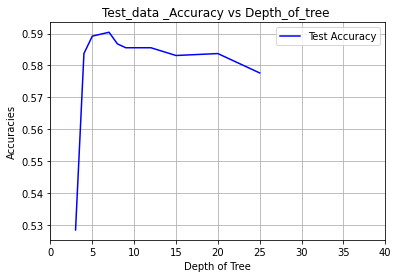

In [27]:
#Accuracy of the tree on different depths----
X_N = [3,4,5,7,8,9,12,15,20,25]
plt.plot(X_N,test_accuracies, 'b', label='Test Accuracy')
plt.title('Test_data _Accuracy vs Depth_of_tree ')
plt.ylabel('Accuracies')
plt.xlabel('Depth of Tree')
plt.legend()
plt.grid()
plt.xticks(np.arange(0,45, step=5))
plt.show()

In [30]:
# best tree is formed at depth of 5 as same as information gain
best_tree= decision_tree_algorithm(train_df,7)

In [31]:
pprint(best_tree)

{'rownumber <= 0.529852': [{'peaknumber <= 0.640941': [{'modularratio <= -0.2041715': [{'rownumber <= 0.1276505': [{'exploitation <= -2.488079': [{'intercolumnardistance <= -3.035905': ['A',
                                                                                                                                                                                          'H']},
                                                                                                                                                  {'lowermargin <= 0.368992': [{'modularratio <= -0.4117955': ['A',
                                                                                                                                                                                                               'Y']},
                                                                                                                                                                               {'uppermargin <